In [1]:
import numpy as np
import pandas as pd

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

- データセットのダウンロード

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

- データセットの確認

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


- 画像データの可視化

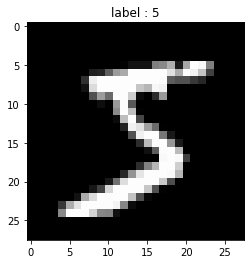

In [4]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

- 前処理

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


- データの次元変換

In [6]:
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [7]:
#X_train = X_train[:3000]
#y_train = y_train[:3000]
#X_test = X_test[:500]
#y_test = y_test[:500]

In [8]:
X_train.shape, X_test.shape

((60000, 1, 28, 28), (10000, 1, 28, 28))

In [9]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

print(y_test_one_hot.shape) # (60000, 10)

(60000,)
(60000, 10)
float64
(10000, 10)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape, y_train.shape) # (48000, 784)
print(X_val.shape, y_val.shape) # (12000, 784)

(48000, 1, 28, 28) (48000, 10)
(12000, 1, 28, 28) (12000, 10)


### 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$


$\alpha$ : 学習率


$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$


$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


$M$ : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

In [11]:
class Conv2d:
    def __init__(self, activation, optimizer, filter_num, input_channel, filter_size, stride=1, pad=0):
        self.stride = stride
        self.pad = pad
        
        self.activation = activation
        self.optimizer = optimizer
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
        if self.activation == 'sigmoid':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)            
        elif self.activation == 'tanh':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)          
        elif self.activation == 'relu':
            initializer = HeInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)        
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def _calc_out_shape(self, H, FH, W, FW):
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        return out_h, out_w

    def _im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
        ----------
        input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
        filter_h : フィルターの高さ
        filter_w : フィルターの幅
        stride : ストライド
        pad : パディング
        Returns
        -------
        col : 2次元配列
        """
        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        
        return col

    def _col2im(self, col, input_shape, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
        ----------
        col :
        input_shape : 入力データの形状（例：(10, 1, 28, 28)）
        filter_h :
        filter_w
        stride
        pad
        Returns
        -------
        """
        N, C, H, W = input_shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape #フィルタ(FN : フィルタ数、C : チャネル数、FH : フィルタ高さ、FW : フィルタ幅)
        N, C, H, W = x.shape #入力データ(N : バッチ数、C : チャネル数、H : 高さ、W : 幅)
        
        # 2次元畳み込み後の出力サイズ(h : 高さ、w : 幅)
        out_h, out_w = self._calc_out_shape(H, FH, W, FW)

        # im2colによる4次元のデータの2次元への展開
        col = self._im2col(x, FH, FW, self.stride, self.pad)
        
        col_W = self.W.reshape(FN, -1).T # フィルタの転置
        out = np.dot(col, col_W) + self.b # 畳み込み演算
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) # 出力サイズの整形

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)    
        dx = self._col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

### 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である

In [12]:
def _calc_out_shape(H, FH, W, FW, pad=0, stride=1):
    out_h = int(1 + (H + 2*pad - FH) / stride)
    out_w = int(1 + (W + 2*pad - FW) / stride)
    
    return out_h, out_w

In [13]:
_calc_out_shape(6, 3, 6, 3)

(4, 4)

### 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）


$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ


$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス


$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値


$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [14]:
class MaxPool2D:
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def _im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
        ----------
        input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
        filter_h : フィルターの高さ
        filter_w : フィルターの幅
        stride : ストライド
        pad : パディング
        Returns
        -------
        col : 2次元配列
        """
        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        
        return col
        
    def _col2im(self, col, input_shape, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
        ----------
        col :
        input_shape : 入力データの形状（例：(10, 1, 28, 28)）
        filter_h :
        filter_w
        stride
        pad
        Returns
        -------
        """
        N, C, H, W = input_shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
                
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = self._im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self._col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

### 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

__回答なし__

### 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [15]:
class Flatten():
    def __init__(self):
        self.X_shape = None
    
    def forward(self, X):
        # 1次元化
        X_1d = X.reshape(X.shape[0], -1)
        
        # shapeの記録
        self.X_shape = X.shape
        
        return X_1d    

    def backward(self, X):
        # shapeの返戻
        X = X.reshape(self.X_shape)
        
        return X

### 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

In [16]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [17]:
class Scratch2dCNNClassifier:
    """
    ディープニューラルネットワーク分類器

    Parameters
    --------------
    activaiton : {'sigmoid', 'tanh', 'relu'} 
        活性化関数の種類
    n_nodes : list
        ノードの構成 例 [400, 200, 100]
    n_output : int
        出力層の数
    alpha : float
        学習率
    optimizer :  {'sgd', 'adagrad'}
        最適化手法の種類
    filter_num : int
        フィルタ数
    filter_size : int
        フィルタサイズ
    stride : int(初期値 : 1)
        ストライド
    pad : int(初期値 : 0)
        パディング
        
    Attributes
    -------------
    FC[n_layers] :  dict
        結合層を管理する辞書
    activation : dict
        活性化関数を管理する辞書
    self.epochs : int
        エポック数(初期値：10)
    self.batch_size : int
        バッチサイズ(初期値：20)
    self.n_features : int
        特徴量の数
    self.val_is_true : boolean
        検証用データの有無    
    self.loss : 空のndarray
        訓練データに対する損失の記録
    self.loss_val : 空のndarray
        検証データに対する損失の記録        
    """    
    def __init__(self, activation, n_nodes, n_output, lr, optimizer, filter_num, filter_size):
        self.select_activation = activation
        self.n_nodes = n_nodes
        self.n_output = n_output
        self.lr = lr
        self.select_optimizer = optimizer
        
        self.filter_num  = filter_num    # フィルタ数
        self.filter_size   = filter_size    # フィルタサイズ        
        self.stride          = 1               #ストライド
        self.pad             = 0               #パディング
            
    def _initialize_n_layers(self):
        """
        N層を初期化する。
        sigmoid関数とtanh関数が活性化関数の場合：Xavierを初期値
        ReLU関数が活性化関数の場合：Heを初期値
        """
        self.activation = dict()
        self.FC = dict()
        #プーリング層から全結合層につなぐFCクラスのインスタンス化
        if self.select_activation == 'sigmoid':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Sigmoid()
        elif self.select_activation == 'tanh':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Tanh()
        elif self.select_activation == 'relu':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = ReLU()

        #全結合層間のFCクラスのインスタンス化
        for n_layer in range(len(self.n_nodes)):            
            if n_layer == len(self.n_nodes) -1:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output, 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
            else:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1], 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Sigmoid()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Tanh()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = ReLU()
                    
    def _calc_out_shape(self, H, FH, W, FW, layer):
        """
        ConvolutionレイヤとPoolingレイヤの出力サイズを計算する関数
        """        
        if layer == 'conv':
            out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
            out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        elif layer == 'pool':
            out_h = int(1 + (H - FH) / self.stride)
            out_w = int(1 + (W - FW) / self.stride)
        
        return out_h, out_w    
    
    def fit(self, X, y, epochs=10, batch_size=20):  
        self.epochs = epochs                            # エポック数     
        self.batch_size = batch_size               # バッチサイズ
        self.loss = np.zeros(self.epochs)        # 学習曲線・目的関数の出力用(訓練データ)
        self.loss_val = np.zeros(self.epochs) # 学習曲線・目的関数の出力用(検証データ)        
        
        #最適化クラスのインスタンス化
        if self.select_optimizer == 'sgd':
            self.optimizer = SGD(self.lr)
        elif self.select_optimizer == 'adagrad':
            self.optimizer = AdaGrad(self.lr)            
        
        #入力データのshape
        self.input_channel = X.shape[1]
        self.input_h = X.shape[2]
        self.input_w = X.shape[3]
        
        #畳み込み層クラスのインスタンス化
        self.conv = Conv2d(self.select_activation, self.optimizer, self.filter_num, self.input_channel, self.filter_size)
        
        #活性化関数クラスのインスタンス化
        if self.select_activation == 'sigmoid':
            self.activation_conv = Sigmoid()
        elif self.select_activation == 'tanh':
            self.activation_conv = Tanh()
        elif self.select_activation == 'relu':
            self.activation_conv = ReLU()
            
        #プーリング層クラスのインスタンス化
        self.pool = MaxPool2D()   

        # 平滑化クラスのインスタンス化
        self.flatten = Flatten()

        #全結合前のサイズ
        out_h, out_w = self._calc_out_shape(self.input_h, self.filter_size, self.input_w, self.filter_size, 'conv')
        out_h, out_w = self._calc_out_shape(out_h, self.filter_size, out_w, self.filter_size, 'pool')
        self.out_size = out_h * out_w * self.filter_num
        
        #N層の初期化
        self._initialize_n_layers()
        
        #ミニバッチの取得
        get_mini_batch = GetMiniBatch(X, y, self.batch_size)
        
        for epoch in range(self.epochs):
            print("epoch ", epoch + 1 , " processing . . .")
            for mini_X_train,  mini_y_train in get_mini_batch:
                self.X_ = mini_X_train
                self.y_ = mini_y_train
                
                #フォワードプロバゲーション
                #畳み込み層
                self.A = self.conv.forward(self.X_)
                #活性化関数
                self.Z = self.activation_conv.forward(self.A)
                #プーリング層
                self.P = self.pool.forward(self.Z)
                #平滑化
                self.F = self.flatten.forward(self.P)
                
                self.A = self.FC[0].forward(self.F)
                self.Z = self.activation[0].forward(self.A)       
                for n_layer in range(1, len(self.n_nodes) + 1):
                    self.A = self.FC[n_layer].forward(self.Z)
                    self.Z = self.activation[n_layer].forward(self.A)
                
                #バックプロパゲーション
                self.dA, self.loss[epoch] = self.activation[len(self.n_nodes)].backward(self.Z, self.y_) #最終層, 交差エントロピー誤差
                self.dZ = self.FC[len(self.n_nodes)].backward(self.dA) #最終層
                for n_layer in reversed(range(0, len(self.n_nodes))): #最終層 - 1
                    self.dA = self.activation[n_layer].backward(self.dZ)
                    self.dZ = self.FC[n_layer].backward(self.dA)

                #shapeの戻入
                self.dF = self.flatten.backward(self.dZ)
                
                #プーリング層
                self.dP = self.pool.backward(self.dF)
                #活性化関数
                self.dA = self.activation_conv.backward(self.dP)
                #畳み込み層
                self.dZ = self.conv.backward(self.dA)
                
    def predict(self,X):
        # フォワードプロバゲーション
        #畳み込み
        self.A = self.conv.forward(X)
        #活性化関数
        self.Z = self.activation_conv.forward(self.A)
        #プーリング層
        self.P = self.pool.forward(self.Z)
        #平滑化
        self.F = self.flatten.forward(self.P)

        self.A = self.FC[0].forward(self.F)
        self.Z = self.activation[0].forward(self.A)    
        for n_layer in range(1, len(self.n_nodes) + 1):
            self.A = self.FC[n_layer].forward(self.Z)
            self.Z = self.activation[n_layer].forward(self.A)
        
        return np.argmax(self.Z, axis=1)

In [18]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        
        return np.dot(self.X, self.W) + self.B
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)

        # 更新
        self = self.optimizer.update(self)
        
        return dZ

In [19]:
class XavierInitializer:
    """
    Xavierのクラス
    """
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size 
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """     
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size, self.filter_size)
        else: # 全結合層
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)       
        
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """       
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            B = np.random.randn(self.filter_num)
        else: # 全結合層
            B = np.zeros(n_nodes2)
        
        return B

In [20]:
class HeInitializer:
    """
    Heのクラス
    """
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size       
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """      
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size, self.filter_size) * np.sqrt(2 / self.filter_num) 
        else: # 全結合層
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """      
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            B = np.random.randn(self.filter_num)
        else: # 全結合層
            B = np.random.randn(n_nodes2)
        
        return B

In [21]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        
        return layer

In [22]:
class AdaGrad:
    """
    AdaGradのクラス
    Parameters
    ----------
    alpha : 学習率
    
    Attributes
    -------------
    lr : 学習率
    HW : int(初期値), ndarray
    HB :  int(初期値), ndarray
    """    
    def __init__(self, lr):
        self.lr = lr
        self.HW= 0 # 初期値：0
        self.HB = 0 # 初期値：0       

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #初期化
        self.HW = np.zeros_like(layer.W)
        self.HB = np.zeros_like(layer.B)
        
        #更新
        self.HW = self.HW + (layer.dW**2) #/ layer.dB.shape[0]
        self.HB = self.HB + (layer.dB**2).mean(axis=0)
        layer.W = layer.W - self.lr * 1 / np.sqrt(self.HW + 1e-7) * layer.dW #/ layer.dB.shape[0]
        layer.B = layer.B - self.lr * 1 / np.sqrt(self.HB + 1e-7) * layer.dB.mean(axis=0)
        
        return layer

In [23]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        self.Z = 1.0 / (1.0 + np.exp(-self.A))
        
        return self.Z
    
    def backward(self, dZ):

        return dZ * (1 - self.Z) * self.Z

In [24]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        return np.tanh(self.A)
    
    def backward(self, dZ):
        
        return dZ * (1.0 - (np.tanh(self.A) ** 2))

In [25]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, A):    
        self.A = A
      
        return np.maximum(self.A, 0)
    
    def backward(self, dZ):
            
        return np.where(self.A > 0, dZ, 0)

In [26]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        
        return np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
    
    def backward(self, Z, y):
        
        dA = Z - y
        
        # 交差エントロピー誤差
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(Z)) / batch_size

        return dA, loss

In [27]:
model = Scratch2dCNNClassifier(activation='relu', n_nodes=[400, 200, 100], n_output=10, lr=0.001, optimizer='sgd', filter_num=3, filter_size=3)
model.fit(X_train, y_train, epochs=10, batch_size=20)
y_pred = model.predict(X_test)

epoch  1  processing . . .
epoch  2  processing . . .
epoch  3  processing . . .
epoch  4  processing . . .
epoch  5  processing . . .
epoch  6  processing . . .
epoch  7  processing . . .
epoch  8  processing . . .
epoch  9  processing . . .
epoch  10  processing . . .


In [28]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [29]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))

accuracy : 0.9802


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.96      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.99      0.99      1028
           8       0.93      0.99      0.96       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。


[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

__回答なし__

### 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

__回答なし__

### 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

In [30]:
def calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN):
    out_h = int(1 + (H + 2*pad - FH) / stride)
    out_w = int(1 + (W + 2*pad - FW) / stride)
    
    params = FH * FW * IC * FN + FN # 最後にバイアス項 + FNを加算
        
    activation_size = FN * out_h * out_w
        
    return out_h, out_w, params, activation_size

1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

In [31]:
#入力サイズ
H, W, IC = (144, 144, 3) # IC = input_channel

#フィルタサイズ
FH, FW, FC = (3, 3, 3) # FC(未使用) = filter_channel

#フィルタ数(問題指定のフィルタサイズ 6チャンネルは、フィルタ数の表記と想定)
FN = 6

#ストライド、パディング
stride, pad = 1, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('出力サイズ(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('パラメータ数 : {}'.format(params))

出力サイズ(FN × OH × OW) : 6 × 142 × 142
Activation Size : 120984
パラメータ数 : 168


2.
- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

In [32]:
#入力サイズ
H, W, IC = (60, 60, 24) # IC = input_channel

#フィルタサイズ
FH, FW, FC = (3, 3, 24) # FC(未使用) = filter_channel

#フィルタ数(問題指定のフィルタサイズ 48チャンネルは、フィルタ数の表記と想定)
FN = 48

#ストライド、パディング
stride, pad = 1, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('出力サイズ(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('パラメータ数 : {}'.format(params))

出力サイズ(FN × OH × OW) : 48 × 58 × 58
Activation Size : 161472
パラメータ数 : 10416


3.
- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

In [33]:
#入力サイズ
H, W, IC = (20, 20, 10) # IC = input_channel

#フィルタサイズ
FH, FW, FC = (3, 3, 10) # FC(未使用) = filter_channel

#フィルタ数(問題指定のフィルタサイズ 20チャンネルは、フィルタ数の表記と想定)
FN = 20

#ストライド、パディング
stride, pad = 2, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('出力サイズ(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('パラメータ数 : {}'.format(params))

出力サイズ(FN × OH × OW) : 20 × 9 × 9
Activation Size : 1620
パラメータ数 : 1820


### 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果

__回答なし__